<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab12_nlp-introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12 - Natural Language Processing - Introduction

### Author: Szymon Nowakowski


# Introduction
---------------


# Google Crowdsource Sentiment Dataset  
--------------

It features **43k sentences** with **human-annotated emotion labels** from real-world user-generated content such as feedback, reviews, and comments.

Each sentence can be labeled with **one or more of 27 fine-grained emotion categories**, such as:
- *joy*, *amusement*, *approval*, *sadness*, *anger*, *fear*, *realization*, *pride*, etc.,  
plus an optional **neutral** label.

Because the dataset is **multi-label**, a single sentence may express a combination of emotions (e.g., *pride* and *fear*).

The dataset was released by Google as part of its **Crowdsource project** and is related to the **GoEmotions** initiative. It's particularly valuable for building models that understand nuanced emotional language in realistic user comments.




## Mapping emotions to sentiment

To use the dataset for **sentiment classification**, a rule-based mapping is applied to reduce multi-label emotion annotations into a single sentiment label:

- If **any emotion** in the label set is **positive** → classify as **Positive**
- Else if **any emotion** in the label set is **negative** → classify as **Negative**
- Else → classify as **Neutral**

This decision rule captures the dominant emotional tone of each sentence, simplifying the dataset for use in binary or ternary sentiment classification tasks.

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [11]:
from datasets import load_dataset
import pandas as pd

# Load the GoEmotions dataset (by Google)
dataset = load_dataset("go_emotions")

# Convert to binary sentiment (positive/neutral/negative)
def map_to_sentiment(example):
    positive = {
        1,   # admiration
        2,   # amusement
        3,   # approval
        7,   # caring
        10,  # desire
        12,  # excitement
        14,  # gratitude
        19,  # love
        20,  # optimism
        22,  # pride
        23,  # relief
        26   # joy
    }

    negative = {
        4,   # anger
        5,   # annoyance
        6,   # disapproval
        8,   # confusion
        9,   # disappointment
        11,  # embarrassment
        13,  # fear
        15,  # grief
        16,  # nervousness
        17,  # remorse
        18  # sadness
    }

    neutral = {
        0,   # neutral
        21,  # curiosity (ambiguous, context-specific)
        24,  # realization (realization label is often used for sentences that show understanding, acknowledgment, or reflection, without emotional intensity, like in “Oh, now I get what she meant” )
        25,  # surprise (can be negative or positive, but often context-specific)
        27   # none (used when no emotion is detected)
    }
    labels = set(example["labels"])
    if labels & positive:
        return "positive"
    elif labels & negative:
        return "negative"
    else:
        return "neutral"

# Apply sentiment mapping
dataset = dataset["train"].map(lambda x: {"sentiment": map_to_sentiment(x)})

# Convert to DataFrame for easier use
df = dataset.to_pandas()[["text", "sentiment"]]

print(df.sample(5))  # Show sample entries
print("Rows:", len(df))


                                                    text sentiment
11929  Dayyuuummm!!! If you ever get another one, you...  negative
27426  > neoprene kayaking gloves Thanks will check t...  negative
35543  Not cheating and not using exploits is honorab...  negative
17869  Someone that can check your dash and aa your j...   neutral
31134  watching [NAME] attempt hook shots gives me a ...  positive
Rows: 43410


In [12]:
from sklearn.model_selection import train_test_split

# Split into 80% train and 20% validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

# Check the sizes
print(f"Training size: {len(train_df)}, Validation size: {len(val_df)}")
print(train_df['sentiment'].value_counts(normalize=True))
print(val_df['sentiment'].value_counts(normalize=True))

Training size: 34728, Validation size: 8682
sentiment
neutral     0.391384
positive    0.329158
negative    0.279457
Name: proportion, dtype: float64
sentiment
neutral     0.391384
positive    0.329187
negative    0.279429
Name: proportion, dtype: float64


# Tokenizer
-------------------

To feed text into a neural network, we need to represent words in a "neural-network-ish" way — that is, as numbers. The standard approach is to use a tokenizer, often from a pretrained model. However, since we plan to experiment with our own attention modules later on, **we’ll avoid using any pretrained tokenizer**.

Instead, we’ll go with a simple, word-based tokenization. As part of this, we’ll clean the text by removing any non-standard HTML tags, digits, extra whitespace, and punctuation. We’ll also convert all words to lowercase to ensure consistency.

## Special Tokens: `<PAD>` and `<UNK>`

In our text preprocessing pipeline, we convert each word to a number using a vocabulary. Two special tokens help us handle padding and unknown words.




### `<PAD>` — Padding Token

- Represents empty slots when we need all input sequences to be the same length.
- Assigned index `0`.
- Used so that batches of sentences can be processed together by the model.

For example:  
Original: `[17, 5, 23]`  
Padded:   `[17, 5, 23, 0, 0]` (for a fixed length of 5)




### `<UNK>` — Unknown Token

- Represents any word that is **not in the vocabulary**.
- Assigned index `1`.
- Occurs when:
  1. A word was **too rare in the training data** (appeared only once and was excluded from the vocabulary).
  2. A word appears **only in validation or test data**.

> In our setup, we **excluded all words that appear only once** in the training set.  
> So even in the training data, some tokens are replaced with `<UNK>`.  
> These are called **rare unknowns** — they help the model learn how to handle unusual or unfamiliar words.


By including `<UNK>` during training, we teach the model how to deal with unseen or rare words at test time — which is **crucial for generalization**.


In [16]:
import re
from collections import Counter

PAD_AND_MAX_LEN = 32

# Tokenize with cleaning
def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)       # remove HTML tags
    text = re.sub(r'[^a-z\s]', ' ', text)      # remove digits and punctuation
    text = re.sub(r'\s+', ' ', text).strip()   # normalize whitespace
    return text.split()

# Tokenize text
train_tokens = train_df['text'].apply(tokenize)
val_tokens = val_df['text'].apply(tokenize)

# Build vocabulary from training set — exclude rare words (freq = 1)
token_counter = Counter(token for sentence in train_tokens for token in sentence)
vocab = {
    token: idx + 2    # +2 to account for <PAD> and <UNK> special tokens
    for idx, (token, count) in enumerate(token_counter.items())
    if count > 1
}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# Convert tokens to indices
def tokens_to_indices(tokens, vocab):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

# Pad or truncate sequences to a fixed length
def pad_sequence(seq, max_len=32, pad_value=0):
    if len(seq) < max_len:
        return seq + [pad_value] * (max_len - len(seq))
    else:
        return seq[:max_len]

# Apply both steps to train and val sets

train_df['input_ids'] = train_tokens.apply(lambda tokens: pad_sequence(tokens_to_indices(tokens, vocab), max_len=PAD_AND_MAX_LEN))
val_df['input_ids'] = val_tokens.apply(lambda tokens: pad_sequence(tokens_to_indices(tokens, vocab), max_len=PAD_AND_MAX_LEN))

# Example check
print(train_df[['text', 'input_ids']].head(3))




                                                    text  \
21866  The guy that waived a future hall of famer. Ha...   
5542                                          Stop what?   
38431                                          Oh wow!!!   

                                               input_ids  
21866  [2, 3, 4, 1, 6, 7, 8, 9, 1, 11, 12, 13, 14, 15...  
5542   [17, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
38431  [19, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  


# Prepare Data Loaders
--------------------

We must transform the pandas dataframe to the dataset - it will, among other things, separate input data and labels and then wrap it in a dataloder.

In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 1024

# Map labels to integers
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
train_labels = train_df['sentiment'].map(label2id).values
val_labels = val_df['sentiment'].map(label2id).values

# Convert input_ids and labels to tensors
train_inputs = torch.tensor(train_df['input_ids'].tolist(), dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.long)

val_inputs = torch.tensor(val_df['input_ids'].tolist(), dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_inputs, train_labels)
val_dataset = TensorDataset(val_inputs, val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Classification Neural Network
----------------------

In [21]:
feature_cnt = 4
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net(torch.nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.linear = torch.nn.Linear(feature_cnt, 3)
    def forward(self, index):                    #batches, words
        feature = self.embedding(index)          #batches, words, features
        feature = feature.mean(-2)               #batches, features
        classification = self.linear(feature)    #batches, 3
        return classification

net = Net()

# Training Loop as We know It
----------------

In [23]:
import time
import torch
import torch.nn.functional as F


# Initialize model, optimizer, etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = Net().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

EPOCHS = 1000
train_loss_history = []
val_loss_history = []

# Start training
start_time = time.time()

for epoch in range(EPOCHS):
    net.train()
    train_loss_sum = 0.0
    train_correct = 0
    train_total = 0

    for batch_inputs, batch_labels in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        logits = net(batch_inputs)
        loss = F.cross_entropy(logits, batch_labels)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * batch_inputs.size(0)
        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == batch_labels).sum().item()
        train_total += batch_inputs.size(0)

    avg_train_loss = train_loss_sum / train_total
    train_acc = train_correct / train_total
    train_loss_history.append(avg_train_loss)

    # === Validation ===
    net.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_inputs, batch_labels in val_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            logits = net(batch_inputs)
            loss = F.cross_entropy(logits, batch_labels)

            val_loss_sum += loss.item() * batch_inputs.size(0)
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == batch_labels).sum().item()
            val_total += batch_inputs.size(0)

    avg_val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total
    val_loss_history.append(avg_val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

# End timing
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

Working on cpu
Epoch 000 | Train Loss: 1.1110, Acc: 0.3914 | Val Loss: 1.1057, Acc: 0.3914
Epoch 010 | Train Loss: 1.0786, Acc: 0.3981 | Val Loss: 1.0813, Acc: 0.3948
Epoch 020 | Train Loss: 1.0488, Acc: 0.4508 | Val Loss: 1.0591, Acc: 0.4364
Epoch 030 | Train Loss: 1.0096, Acc: 0.4999 | Val Loss: 1.0339, Acc: 0.4713
Epoch 040 | Train Loss: 0.9710, Acc: 0.5337 | Val Loss: 1.0126, Acc: 0.4941
Epoch 050 | Train Loss: 0.9334, Acc: 0.5665 | Val Loss: 0.9936, Acc: 0.5164
Epoch 060 | Train Loss: 0.8962, Acc: 0.5945 | Val Loss: 0.9763, Acc: 0.5324
Epoch 070 | Train Loss: 0.8602, Acc: 0.6226 | Val Loss: 0.9613, Acc: 0.5464
Epoch 080 | Train Loss: 0.8261, Acc: 0.6449 | Val Loss: 0.9490, Acc: 0.5547
Epoch 090 | Train Loss: 0.7949, Acc: 0.6630 | Val Loss: 0.9398, Acc: 0.5667
Epoch 100 | Train Loss: 0.7665, Acc: 0.6782 | Val Loss: 0.9333, Acc: 0.5744
Epoch 110 | Train Loss: 0.7412, Acc: 0.6909 | Val Loss: 0.9299, Acc: 0.5827
Epoch 120 | Train Loss: 0.7188, Acc: 0.7009 | Val Loss: 0.9289, Acc: 0.58

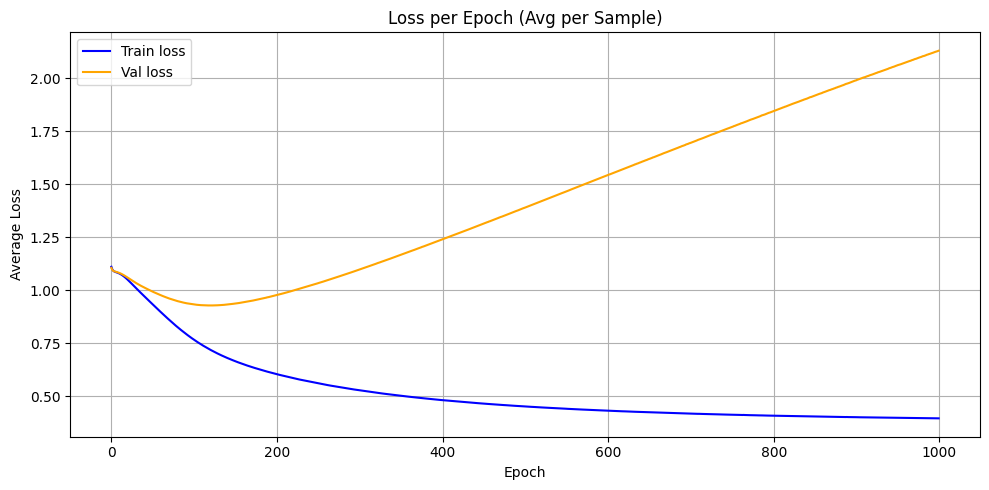

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Train loss", color='blue')
plt.plot(val_loss_history, label="Val loss", color='orange')
plt.title("Loss per Epoch (Avg per Sample)")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()